Algorithm

1. Compute a 1.7 mm space around a contrast target (not too big to catch things other than background
2. Bounding box or dilation
3. Calculate mean and std deviation between bg and contrast target


In [1]:
%load_ext autoreload
%autoreload 2
import itk
import numpy as np
from usqc.data import get_files
from usqc.qc import get_feature_mask, calculate_histogram_metrics, load_and_calculate_histogram_metrics
from usqc.manuscript import PROBE_ORDERED, PROBE_PALETTE, PROBE_PRETTY, CONTRAST_ORDERED, CONTRAST_PRETTY

In [2]:
import usqc.phantom
from glob import glob
from pathlib import Path
# contrast_1_2 1 and 2 'contrast_3cm -9.0' -6.0 -3.0 3.0 6.0 h
# contrast_3
# contrast_4
# contrast_5

def load_and_calculate_fisher_by_dir(probe_dir, pad=1.7):
    '''
    Calculates the Fisher Criterion over the contrast targets images in probe_dir
    
    Contrast targets are named 'contrast_1_2-1.mha', 'contrast_1_2-2.mha', etc.
    
    Parameters
    ----------
    probe_dir : str
        Path to a probe's preprocessed directory, e.g., 'study/preprocessed/clarius-l7hd/'
    pad : float
        Padding around the contrast targets for calculating the background class (in mm)
        
    Returns
    -------
    dict
        phantom_label : list of float, where the list is the Fisher Criterion per replicate file
        
    See also
    --------
    usqc.data.load_and_calculate_fisher
    '''
    ph = usqc.phantom.Phantom()
    
    if Path(probe_dir).name == 'sonivate':
        files_map = {
            'contrast_3cm -9.0' : 'contrast_1',
            'contrast_3cm -6.0' : 'contrast_2',
            'contrast_3cm -3.0' : 'contrast_3',
            'contrast_3cm 3.0' : 'contrast_4',
            'contrast_3cm 6.0' : 'contrast_5',
            'contrast_3cm h' : 'contrast_6'
        }
    else:
        files_map = {
            'contrast_3cm -9.0' : 'contrast_1_2',
            'contrast_3cm -6.0' : 'contrast_1_2',
            'contrast_3cm -3.0' : 'contrast_3',
            'contrast_3cm 3.0' : 'contrast_4',
            'contrast_3cm 6.0' : 'contrast_5',
            'contrast_3cm h' : 'contrast_6'
        }
        
    ans = {}
    
    # glob for the replicate files
    for k, v in files_map.items():
        files_map[k] = glob(probe_dir + '/' + files_map[k] + '*.mha')
    
    for k, v in files_map.items():
        ans[k] = [ load_and_calculate_histogram_metrics(f, k, pad) for f in v ]
    
    return ans

probes =  ['butterfly-iq', 'clarius-l7hd', 'sonoque-l5c', 'sonivate', 'interson-spl01']

probes_fisher = { probe : load_and_calculate_fisher_by_dir(f'../data/phantom_study-202201/preprocessed/{probe}/') for probe in probes }
    

In [3]:
import pandas as pd
def to_pandas(probes_fisher):
    data = {
        'probe' : [],
        'contrast' : [],
        'replicate' : [],
        'fisher' : [],
        'gcnr' : []
    }
    for k, v in probes_fisher.items():
        for c, n in v.items():
            for i in range(len(n)):
                x = n[i]
                data['probe'].append(k)
                data['contrast'].append(c)
                data['replicate'].append(i)
                data['fisher'].append(x[0])
                data['gcnr'].append(x[1])
    return pd.DataFrame(data)
    
df = to_pandas(probes_fisher)
            

<Figure size 1500x800 with 0 Axes>

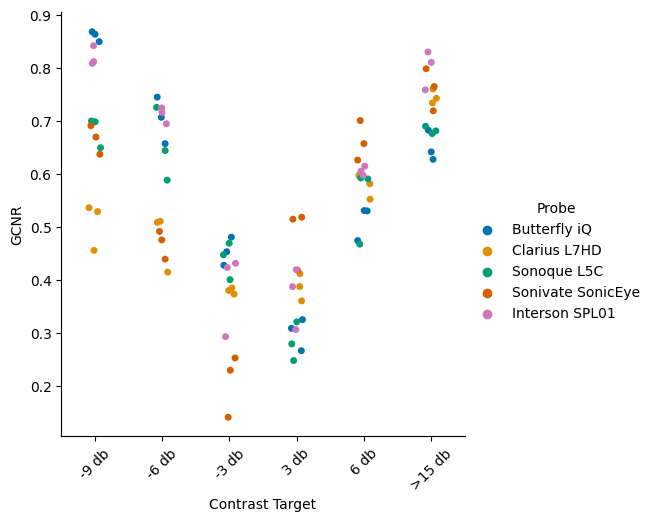

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
tmp = df.rename({ 'probe' : 'Probe', 'contrast' : 'Contrast Target', 'gcnr' : 'GCNR'}, axis=1, inplace=False)
tmp.replace(PROBE_PRETTY, inplace=True)
tmp.replace(CONTRAST_PRETTY, inplace=True)
tmp.Probe = pd.Categorical(tmp.Probe, categories=PROBE_ORDERED, ordered=True)
plt.figure(figsize = (15,8))
ax = sns.catplot(x="Contrast Target", y="GCNR", hue='Probe', data=tmp, palette=PROBE_PALETTE)
plt.xticks(rotation=45)
plt.savefig('../data/phantom_study-202201/analysis/fig-contrast-detail.pdf', bbox_inches='tight')

                Probe Contrast Target  replicate    fisher      GCNR
14     Interson SPL01           -9 db        1.0  2.587160  0.821323
2        Butterfly iQ           -9 db        1.0  3.650050  0.860957
26        Sonoque L5C           -9 db        1.0  1.797358  0.683207
20  Sonivate SonicEye           -9 db        1.0  1.680334  0.666551
8        Clarius L7HD           -9 db        1.0  0.745422  0.507683
1        Butterfly iQ           -6 db        1.0  1.826302  0.703623
25        Sonoque L5C           -6 db        1.0  1.570326  0.653242
7        Clarius L7HD           -6 db        1.0  0.802294  0.478795
19  Sonivate SonicEye           -6 db        1.0  0.752978  0.469553
13     Interson SPL01           -6 db        1.0  2.166500  0.712347
24        Sonoque L5C           -3 db        1.0  0.757973  0.439879
18  Sonivate SonicEye           -3 db        1.0  0.155297  0.208771
0        Butterfly iQ           -3 db        1.0  0.821122  0.454666
6        Clarius L7HD           -3

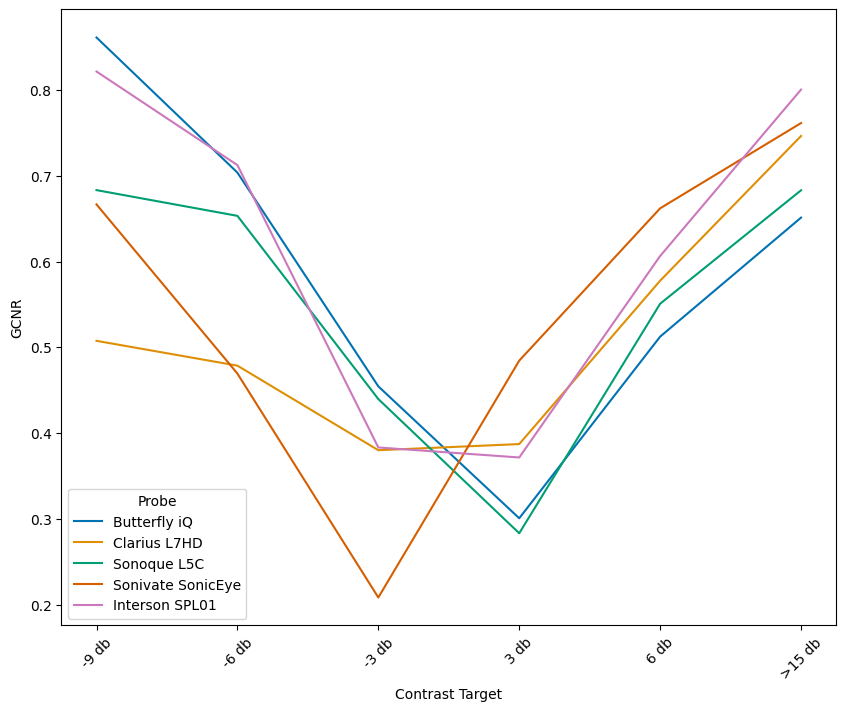

In [17]:
plt.figure(figsize = (10,8))
df_mean = df.groupby(['probe', 'contrast']).mean()
df_mean.reset_index(inplace=True) # need to make this columns again to do the categorical sorting for seaborn
df_mean.contrast = pd.Categorical(df_mean.contrast, 
                      categories=CONTRAST_ORDERED,
                      ordered=True)
df_mean.sort_values('contrast', inplace=True)    

df_mean.rename({ 'probe' : 'Probe', 'contrast' : 'Contrast Target', 'gcnr' : 'GCNR'}, axis=1, inplace=True)
df_mean.replace(PROBE_PRETTY, inplace=True)
df_mean.replace(CONTRAST_PRETTY, inplace=True)
df_mean.Probe = pd.Categorical(df_mean.Probe, categories=PROBE_ORDERED, ordered=True)
print(df_mean)
ax = sns.lineplot(x="Contrast Target", y="GCNR", hue='Probe', data=df_mean, sort=False, palette=PROBE_PALETTE)
plt.xticks(rotation=45)
plt.savefig('../data/phantom_study-202201/analysis/fig-contrast-mean.pdf', bbox_inches='tight')

In [6]:
df_mean[['Probe', 'Contrast Target', 'fisher', 'GCNR']].to_csv('../data/phantom_study-202201/analysis/mean contrast.csv')

In [7]:
# load and plot gain series for clarius and butterfly
data_dir = '../data/phantom_study-202201'

probes_master = [ 'clarius-l7hd', 'butterfly-iq' ]
gains_master = [ 1, 2, 3, 4, 5 ]
contrasts_master = [ 'contrast_3cm -6.0', 'contrast_3cm -3.0', 'contrast_3cm 3.0' ]


probes = []
gains = []
files = []
contrasts = []
fishers = []
gcnrs = []

for p in probes_master:
    for g in gains_master:
        fs = glob(f'{data_dir}/preprocessed/{p}/gain_{str(g)}*.mha')
        for f in fs:
            for c in contrasts_master:
                probes.append(p)
                gains.append(g)
                files.append(f)
                contrasts.append(c)
                try:
                    fisher, gcnr = load_and_calculate_histogram_metrics(f, c, 1.7)
                    fishers.append(fisher)
                    gcnrs.append(gcnr)
                except: # on the lowest gain settings there are missing segmentations
                    fishers.append(None)
                    gcnrs.append(None)


In [8]:
import pandas as pd
df_gain = pd.DataFrame({ 'probe' : probes, 'gain' : gains, 'file' : files, 'contrast' : contrasts, 'fisher' : fishers, 'gcnr' : gcnrs })
df_gain

,probe,gain,file,contrast,fisher,gcnr
0,clarius-l7hd,1,../data/phantom_study-202201/preprocessed/clar...,contrast_3cm -6.0,NaN,NaN
1,clarius-l7hd,1,../data/phantom_study-202201/preprocessed/clar...,contrast_3cm -3.0,NaN,NaN
2,clarius-l7hd,1,../data/phantom_study-202201/preprocessed/clar...,contrast_3cm 3.0,NaN,NaN
3,clarius-l7hd,1,../data/phantom_study-202201/preprocessed/clar...,contrast_3cm -6.0,NaN,NaN
4,clarius-l7hd,1,../data/phantom_study-202201/preprocessed/clar...,contrast_3cm -3.0,NaN,NaN
...,...,...,...,...,...,...
85,butterfly-iq,5,../data/phantom_study-202201/preprocessed/butt...,contrast_3cm -3.0,1.049812,0.532504
86,butterfly-iq,5,../data/phantom_study-202201/preprocessed/butt...,contrast_3cm 3.0,0.397475,0.359128
87,butterfly-iq,5,../data/phantom_study-202201/preprocessed/butt...,contrast_3cm -6.0,2.337349,0.754855
88,butterfly-iq,5,../data/phantom_study-202201/preprocessed/butt...,contrast_3cm -3.0,1.369001,0.602627


In [10]:
import seaborn as sb

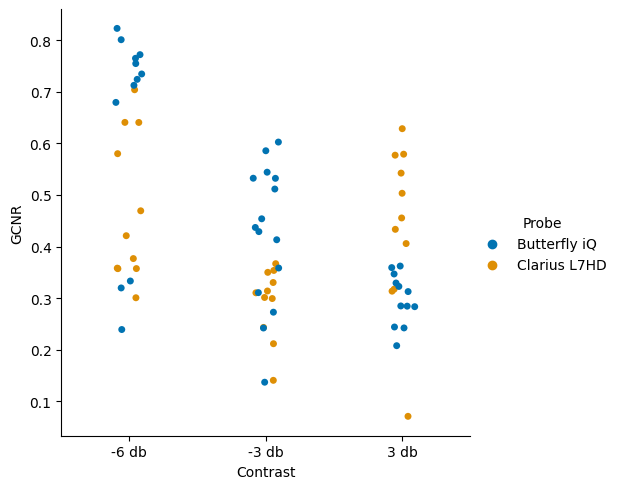

In [20]:
tmp = df_gain.rename({'probe' : 'Probe', 'contrast' : 'Contrast', 'gcnr' : 'GCNR' }, axis=1)
tmp.replace(PROBE_PRETTY, inplace=True)
tmp.replace(CONTRAST_PRETTY, inplace=True)
tmp.Probe = pd.Categorical(tmp.Probe, categories=[ 'Butterfly iQ', 'Clarius L7HD'] , ordered=True)
sb.catplot(
    data=tmp, x="Contrast", y="GCNR", hue='Probe',
    native_scale=True, zorder=1, palette=PROBE_PALETTE)
plt.savefig('../data/phantom_study-202201/analysis/fig-contrast-gain.pdf', bbox_inches='tight')

In [13]:
df_gain_aggr = df_gain.groupby(['probe', 'contrast', 'gain'])[['fisher', 'gcnr']].mean()
df_gain_aggr = df_gain_aggr.reset_index()
df_gain_aggr

,probe,contrast,gain,fisher,gcnr
0,butterfly-iq,contrast_3cm -3.0,1,0.201932,0.310721
1,butterfly-iq,contrast_3cm -3.0,2,0.162806,0.275092
2,butterfly-iq,contrast_3cm -3.0,3,1.018159,0.543198
3,butterfly-iq,contrast_3cm -3.0,4,0.844890,0.462083
4,butterfly-iq,contrast_3cm -3.0,5,1.045171,0.529645
5,butterfly-iq,contrast_3cm -6.0,1,NaN,NaN
6,butterfly-iq,contrast_3cm -6.0,2,0.194128,0.297289
7,butterfly-iq,contrast_3cm -6.0,3,2.254089,0.763495
8,butterfly-iq,contrast_3cm -6.0,4,2.162784,0.738439
9,butterfly-iq,contrast_3cm -6.0,5,2.225394,0.753900


In [14]:
df_gain_aggr.contrast = pd.Categorical(df_gain_aggr.contrast, ordered=True, categories=['contrast_3cm -6.0', 'contrast_3cm -3.0', 'contrast_3cm 3.0'])

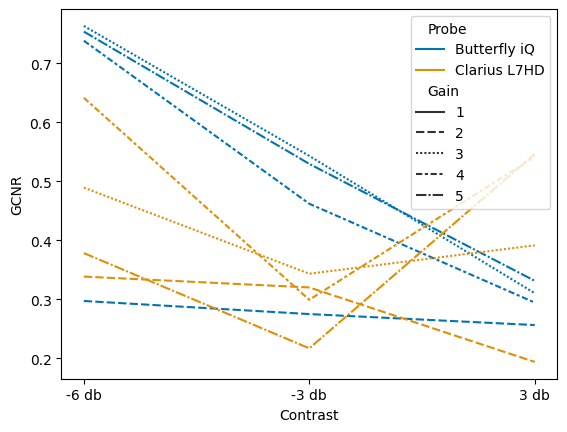

In [16]:
tmp = df_gain_aggr.rename({'probe' : 'Probe', 'contrast' : 'Contrast', 'gcnr' : 'GCNR', 'gain' : 'Gain'}, axis=1)
tmp.replace(PROBE_PRETTY, inplace=True)
tmp.replace(CONTRAST_PRETTY, inplace=True)
tmp.Probe = pd.Categorical(tmp.Probe, categories=[ 'Butterfly iQ', 'Clarius L7HD'] , ordered=True)
sb.lineplot(tmp, x='Contrast', y='GCNR', hue='Probe', style='Gain', palette=PROBE_PALETTE)
plt.savefig('../data/phantom_study-202201/analysis/fig-contrast-gain-detail.pdf', bbox_inches='tight')

<AxesSubplot: xlabel="Fisher's Criterion", ylabel='GCNR'>

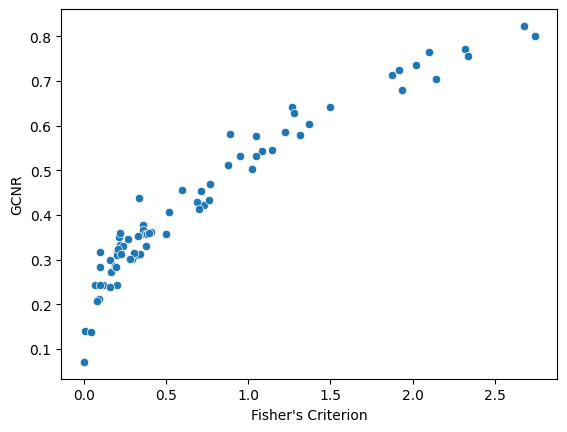

In [40]:
tmp = df_gain.rename({ 'fisher' : 'Fisher\'s Criterion', 'gcnr' : 'GCNR' }, axis=1
                    )
sb.scatterplot(data=tmp, x='Fisher\'s Criterion', y='GCNR')

In [32]:
img = itk.imread('../data/phantom_study-202201/preprocessed/interson-spl01/anechoic_1-1.mha')

In [33]:
print(np.max(img))

227
